### L.A. County places timeseries

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import json
import numpy as np
import altair as alt
import altair_latimes as lat

In [4]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
from datetime import datetime, date
from slugify import slugify

In [5]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

### Counties

In [6]:
counties = pd.read_csv(
    "../../coronavirus-tracker/_notebooks/data/processed/agency-survey/counties-timeseries.csv",
    low_memory=False,
)

In [7]:
la = counties[
    (counties["county"] == "Los Angeles")
    & ((counties["date"] > "2020-11-15") & (counties["date"] < "2021-01-16"))
]

In [8]:
la.head()

,date,county,fips,population,confirmed_cases,deaths,recoveries,confirmed_cases_per_100k,deaths_per_100k,new_confirmed_cases,new_deaths,new_recoveries,agencies_count,agencies_updated,updated,in_progress
7153,2020-11-16,Los Angeles,37,10098052,342489.0,7275.0,13187.0,3391.634347,72.043598,2919.0,6.0,71.0,3.0,3.0,True,False
7154,2020-11-17,Los Angeles,37,10098052,344741.0,7300.0,13244.0,3413.935678,72.291171,2252.0,25.0,57.0,3.0,3.0,True,False
7155,2020-11-18,Los Angeles,37,10098052,348536.0,7337.0,13348.0,3451.517184,72.657578,3795.0,37.0,104.0,3.0,3.0,True,False
7156,2020-11-19,Los Angeles,37,10098052,353479.0,7365.0,13435.0,3500.467219,72.934859,4943.0,28.0,87.0,3.0,3.0,True,False
7157,2020-11-20,Los Angeles,37,10098052,357637.0,7397.0,13515.0,3541.643477,73.251752,4158.0,32.0,80.0,3.0,3.0,True,False


### Regions

In [9]:
regions = pd.read_csv(
    "../../coronavirus-tracker/_notebooks/data/processed/agency-survey/regions-cases-timeseries.csv",
    low_memory=False,
)

In [10]:
socal = regions[
    (regions["region"] == "Southern California")
    & ((regions["date"] > "2020-11-15") & (regions["date"] < "2021-01-16"))
]

In [11]:
socal[
    socal["new_confirmed_cases_seven_day_per_100k"]
    == socal["new_confirmed_cases_seven_day_per_100k"].max()
][["date", "new_confirmed_cases_seven_day_per_100k"]]

,date,new_confirmed_cases_seven_day_per_100k
1874,2021-01-10,1001.84761


In [12]:
alt.Chart(socal).mark_line().encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(tickCount=5, format=("%b. %d"), grid=False, tickColor="#ffffff"),
    ),
    y=alt.Y(
        "new_confirmed_cases_seven_day_per_100k",
        title="",
        axis=alt.Axis(tickColor="#ffffff"),
    ),
).properties(width=500, height=300).configure_axis()

alt.Chart(...)

---

In [13]:
cases = pd.read_csv(
    "../../coronavirus-tracker/_notebooks/data/processed/places/timeseries.csv",
    low_memory=False,
)

### Get places in Los Angeles County

In [14]:
places = cases[(cases["zcta_id"].isna()) & (cases["county"] == "Los Angeles")]

In [15]:
places_latest = places[places["date"] == places["date"].max()]

In [16]:
places_latest.head()

,name,date,county,fips,slug,confirmed_cases_note,confirmed_cases,lat,lon,population,zcta_id,id,new_confirmed_cases,new_confirmed_cases_seven_day_total,new_confirmed_cases_seven_day_average,new_confirmed_cases_fourteen_day_total,new_confirmed_cases_fourteen_day_average,confirmed_cases_per_100k,new_confirmed_cases_per_100k,new_confirmed_cases_seven_day_per_100k,new_confirmed_cases_fourteen_day_per_100k
66956,Acton,2021-02-10,Los Angeles,37,unincorporated-acton,NaN,409,34.481366,-118.216138,7971.0,NaN,Unincorporated - Acton,0.0,9.0,1.285714,21.0,1.500000,5131.100238,0.0,112.909296,263.455024
67288,Adams-Normandie,2021-02-10,Los Angeles,37,los-angeles-adams-normandie,NaN,1118,34.029122,-118.302396,8202.0,NaN,Los Angeles - Adams-Normandie,0.0,27.0,3.857143,73.0,5.214286,13630.821751,0.0,329.188003,890.026823
67620,Agoura Hills,2021-02-10,Los Angeles,37,city-of-agoura-hills,NaN,907,34.151007,-118.760876,20883.0,NaN,City of Agoura Hills,0.0,24.0,3.428571,59.0,4.214286,4343.245702,0.0,114.926016,282.526457
67952,Agua Dulce,2021-02-10,Los Angeles,37,unincorporated-agua-dulce,NaN,242,34.497963,-118.323810,4158.0,NaN,Unincorporated - Agua Dulce,0.0,11.0,1.571429,37.0,2.642857,5820.105820,0.0,264.550265,889.850890
68284,Alhambra,2021-02-10,Los Angeles,37,city-of-alhambra,NaN,6430,34.083961,-118.135504,86724.0,NaN,City of Alhambra,0.0,145.0,20.714286,380.0,27.142857,7414.325907,0.0,167.197085,438.171671


In [17]:
len(places_latest)

334

---

### Cases during the surge? 

In [59]:
surge_places = places[
    (places["date"] > "2020-11-15") & (places["date"] < "2021-01-01")
][["name", "date", "new_confirmed_cases_seven_day_per_100k"]]

In [60]:
losangeles = surge_places[
    (surge_places["name"].str.contains("Leimert Park"))
    | surge_places["name"].str.contains("Playa Del Rey")
]

In [61]:
alt.Chart(losangeles).mark_line().encode(
    x=alt.X(
        "date:T",
        axis=alt.Axis(tickCount=5, format=("%b. %d"), grid=False, tickColor="#ffffff"),
    ),
    y=alt.Y(
        "new_confirmed_cases_seven_day_per_100k",
        title="",
        axis=alt.Axis(tickColor="#ffffff"),
    ),
    facet=alt.Facet("name:N", columns=2, title=""),
).properties(width=500, height=300).configure_axis()

alt.Chart(...)

### Change from Nov. 15 to Dec. 15?

In [62]:
surge_change = places[
    (places["date"] == "2020-11-15") | (places["date"] == "2021-01-15")
][["name", "date", "new_confirmed_cases_seven_day_per_100k"]]

In [63]:
surge_change.head()

,name,date,new_confirmed_cases_seven_day_per_100k
66869,Acton,2020-11-15,75.272864
66930,Acton,2021-01-15,426.546230
67201,Adams-Normandie,2020-11-15,207.266520
67262,Adams-Normandie,2021-01-15,902.218971
67533,Agoura Hills,2020-11-15,71.828760


In [64]:
surge_change_pivot = (
    pd.pivot_table(
        surge_change[surge_change["new_confirmed_cases_seven_day_per_100k"] > 0],
        values="new_confirmed_cases_seven_day_per_100k",
        index=["name"],
        columns=["date"],
        fill_value=0,
    )
    .dropna()
    .reset_index()
)

In [65]:
surge_change_pivot.rename(
    columns={"2020-11-15": "mid_november", "2021-01-15": "mid_january"}, inplace=True
)

In [66]:
surge_change_pivot[["mid_november", "mid_january"]] = round(
    surge_change_pivot[["mid_november", "mid_january"]], 2
)

In [67]:
surge_change_pivot["change"] = round(
    (
        (surge_change_pivot["mid_january"] - surge_change_pivot["mid_november"])
        / surge_change_pivot["mid_november"]
    )
    * 100,
    2,
)

In [68]:
surge_change_pivot.sort_values("change", ascending=False).head(20)

date,name,mid_november,mid_january,change
118,La Habra Heights,0.00,18.33,inf
15,Avalon,0.00,51.69,inf
194,Rolling Hills,0.00,309.28,inf
242,Unincorporated - Angeles National Forest,0.00,160.64,inf
275,West Antelope Valley,0.00,661.81,inf
241,Twin Lakes/Oat Mountain,0.00,482.51,inf
112,Irwindale,0.00,1370.80,inf
127,Lake Manor,0.00,730.37,inf
250,Unincorporated - Monrovia,25.77,747.23,2799.61
282,West Rancho Dominguez,73.58,1986.75,2600.12


In [69]:
surge_change_pivot_min_max = pd.concat(
    [
        surge_change_pivot.sort_values("change", ascending=False).head(20),
        surge_change_pivot.sort_values("change", ascending=False).tail(20),
    ]
)

In [70]:
surge_change_pivot_min_max.head()

date,name,mid_november,mid_january,change
118,La Habra Heights,0.0,18.33,inf
15,Avalon,0.0,51.69,inf
194,Rolling Hills,0.0,309.28,inf
242,Unincorporated - Angeles National Forest,0.0,160.64,inf
275,West Antelope Valley,0.0,661.81,inf


In [71]:
surge_change_pivot_min_max.rename(
    columns={"mid_november": "2020-11-15", "mid_january": "2021-01-15"}, inplace=True
)

In [72]:
surge_change_melt = surge_change_pivot_min_max.melt(id_vars=["name"], var_name="date")

In [73]:
surge_change_melt.rename(columns={"value": "rate"}, inplace=True)

In [74]:
surge_change_melt = surge_change_melt[surge_change_melt["date"] != "change"]

In [75]:
surge_change_melt["date"] = surge_change_melt["date"]

In [76]:
surge_change_melt.head()

,name,date,rate
0,La Habra Heights,2020-11-15,0.0
1,Avalon,2020-11-15,0.0
2,Rolling Hills,2020-11-15,0.0
3,Unincorporated - Angeles National Forest,2020-11-15,0.0
4,West Antelope Valley,2020-11-15,0.0


---

In [77]:
alt.Chart(surge_change_melt).mark_line(size=5, color="red").encode(
    x=alt.X("date:O"),
    y=alt.Y("rate", title=""),
    facet=alt.Facet("name", columns=8),
).properties(
    height=150,
    width=150,
    title="Places with largest, smallest coronavirus case rate increases",
)

alt.Chart(...)

---

In [78]:
places_map = gpd.read_file(
    "input/cities-neighborhoods-unincorporated-la-county.geojson"
).fillna("")

In [79]:
places_map["NAME"] = np.where(
    (places_map["LCITY"] == "Los Angeles") | (places_map["LCITY"] == "Unincorporated"),
    places_map["COMMUNITY"],
    places_map["LCITY"],
)

In [80]:
places_map_geo = places_map.merge(
    surge_change_pivot, left_on="NAME", right_on="name", how="inner"
)

In [81]:
len(places_map_geo)

309

In [82]:
places_map_geo.head()

,OBJECTID,LCITY,COMMUNITY,LABEL,CONFIRMED,SUSPECTED,RECOVERED,DEATHS,Shape__Area,Shape__Length,geometry,NAME,name,mid_november,mid_january,change
0,1,Agoura Hills,,City of Agoura Hills,6.0,,,,2.179401e+08,80374.083443,"POLYGON ((-118.72865 34.16793, -118.73655 34.1...",Agoura Hills,Agoura Hills,71.83,397.45,453.32
1,10,Bellflower,,City of Bellflower,10.0,,,,1.723708e+08,59306.645225,"POLYGON ((-118.10976 33.90982, -118.10984 33.9...",Bellflower,Bellflower,144.08,1130.76,684.81
2,11,Beverly Hills,,City of Beverly Hills,21.0,,,,1.592823e+08,86925.774581,"POLYGON ((-118.39160 34.11243, -118.39230 34.1...",Beverly Hills,Beverly Hills,98.49,492.47,400.02
3,12,Burbank,,City of Burbank,7.0,,,,4.835028e+08,102151.396677,"POLYGON ((-118.30781 34.16116, -118.30451 34.1...",Burbank,Burbank,146.48,600.86,310.20
4,13,Calabasas,,City of Calabasas,7.0,,,,3.836134e+08,149118.510757,"POLYGON ((-118.69385 34.16856, -118.69454 34.1...",Calabasas,Calabasas,57.56,386.47,571.42


### Output geojson

In [83]:
places_map_geo.to_file("output/places_map_geo.geojson", driver="GeoJSON")

In [84]:
!mapshaper 'input/cities-neighborhoods-unincorporated-la-county.geojson' -simplify dp 25% -o format=geojson 'input/cities-neighborhoods-unincorporated-la-county-simply.geojson'

[simplify] Repaired 1 intersection
[o] Wrote input/cities-neighborhoods-unincorporated-la-county-simply.geojson


In [85]:
!mapshaper 'output/places_map_geo.geojson' -simplify dp 30% -o format=geojson 'output/places_map_geo_simply.geojson'

[o] Wrote output/places_map_geo_simply.geojson


<AxesSubplot:>

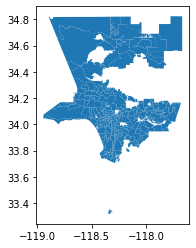

In [86]:
places_map_geo.plot()

In [87]:
places_map_slim = places_map_geo[
    ["OBJECTID", "name", "mid_november", "mid_january", "change"]
].sort_values("change", ascending=False)

In [89]:
surge_change_melt.to_csv("output/surge_change_melt.csv", index=False)